In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss

import lightfm
import lightfm.data as ld
import lightfm.evaluation as lv

import tqdm
import json
import optuna

import tensorboardX as tb

import matplotlib.pyplot as pl
import seaborn as sns

np.random.seed(31337)

/Users/n.anokhin/Projects/virtualenv/recsys-course-itmo-2022/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [2]:
DATA_DIR = "/Users/n.anokhin/Desktop/"

In [3]:
data = pd.read_json(DATA_DIR + "data.json", lines=True).drop_duplicates(subset=["user", "track"])

positives = data[data["time"] > 0.8].copy()
positives["test"] = np.random.random(len(positives)) > 0.8

## Train LightFM

In [8]:
train_data = positives[~positives["test"]]
test_data = positives[positives["test"]]

In [40]:
dataset = ld.Dataset()
dataset.fit(positives["user"], positives["track"])

In [42]:
train_interactions, _ = dataset.build_interactions(train_data[["user", "track"]].itertuples(index=False, name=None))
test_interactions, _ = dataset.build_interactions(test_data[["user", "track"]].itertuples(index=False, name=None))

In [49]:
def fit_model(epochs=3, at=10, loss="warp", no_components=30, learning_rate=0.01, max_sampled=10, user_alpha=0.0, item_alpha=0.0, threads=30, verbose=False):
    model = lightfm.LightFM(
        no_components=no_components,
        loss=loss,
        learning_rate=learning_rate,
        max_sampled=max_sampled,
        user_alpha=user_alpha,
        item_alpha=item_alpha,
    )

    precisions_at = []
    for epoch in range(epochs):
        model = model.fit_partial(train_interactions, num_threads=threads)
        precision_at = lv.precision_at_k(model, test_interactions, train_interactions=train_interactions, k=at, num_threads=threads)
        if verbose:
            print(f"{epoch}:\t{np.mean(precision_at)} +/- {ss.sem(precision_at) * 1.96}")
        precisions_at.append(np.mean(precision_at))
            
    return model, precisions_at


def objective(trial):
    loss = trial.suggest_categorical("loss", ["bpr"])
    no_components = trial.suggest_categorical("no_components", [10, 30, 50])
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.01])
    max_sampled = trial.suggest_categorical("max_sampled", [10, 20, 50, 100])
    user_alpha = trial.suggest_categorical("user_alpha", [0.0, 0.001, 0.01])
    item_alpha = trial.suggest_categorical("item_alpha", [0.0, 0.001, 0.01])
    
    model, precisions_at = fit_model(
        epochs=1, 
        at=10,
        loss=loss,
        no_components=no_components, 
        learning_rate=learning_rate, 
        max_sampled=max_sampled, 
        user_alpha=user_alpha, 
        item_alpha=item_alpha,
    )
    
    return precisions_at[-1]

In [50]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=2)
best_params = study.best_params

[I 2022-03-14 16:08:17,803] A new study created in memory with name: no-name-838a0e5a-8473-4f25-8e1f-e7ed477b2524
[I 2022-03-14 16:08:29,804] Trial 0 finished with value: 0.0003183543449267745 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.001, 'max_sampled': 50, 'user_alpha': 0.01, 'item_alpha': 0.0}. Best is trial 0 with value: 0.0003183543449267745.
[I 2022-03-14 16:08:41,371] Trial 1 finished with value: 0.0007958858623169363 and parameters: {'loss': 'bpr', 'no_components': 10, 'learning_rate': 0.01, 'max_sampled': 10, 'user_alpha': 0.01, 'item_alpha': 0.001}. Best is trial 1 with value: 0.0007958858623169363.


In [51]:
best_params

{'loss': 'bpr',
 'no_components': 10,
 'learning_rate': 0.01,
 'max_sampled': 10,
 'user_alpha': 0.01,
 'item_alpha': 0.001}

In [ ]:
model, precisions_at = fit_model(
    epochs=30,
    at=10,
    loss=best_params["loss"],
    no_components=best_params["no_components"], 
    learning_rate=best_params["learning_rate"], 
    max_sampled=best_params["max_sampled"],
    user_alpha=best_params["user_alpha"],
    item_alpha=best_params["item_alpha"],
    verbose=True,
)

0:	0.000538753520231694 +/- 0.0001587718254995448
1:	0.0006244643591344357 +/- 0.00017086179927372784
2:	0.000269376760115847 +/- 0.00011242055668637473
3:	0.00018366597942076623 +/- 9.286809684451755e-05
4:	0.000146932783536613 +/- 8.307903060526384e-05
5:	8.571079524699599e-05 +/- 6.347210982983614e-05


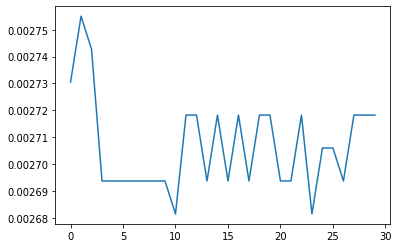

In [23]:
figure, ax = pl.subplots()

ax.plot(np.arange(len(precisions_at)), precisions_at)

pass

## Save track embeddings

In [24]:
biases, embeddings = model.get_item_representations()

In [25]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)
track_meta["dataset_index"] = track_meta["track"].map(lambda t: dataset.mapping()[2].get(t))

In [26]:
dataset_tracks = track_meta[pd.notnull(track_meta["dataset_index"])].sort_values("dataset_index")

In [27]:
writer = tb.SummaryWriter(comment='msd_ligtfm_embeddings', log_dir=DATA_DIR + "tb")
writer.add_embedding(embeddings, metadata=list(dataset_tracks[["artist", "title"]].itertuples(index=False, name=None)), tag="lightfm", metadata_header=["artist", "title"])
writer.close()

## Compute top recommendations

In [28]:
tracks = dataset_tracks["track"].values
users = [user for user, index in sorted(dataset.mapping()[0].items(), key=lambda kv: kv[1])]

In [29]:
with open(DATA_DIR + "recommendations.json", "w") as rf:
    for user_index in tqdm.tqdm(range(dataset.user_features_shape()[0])):
        predictions = model.predict(user_index, np.arange(dataset.item_features_shape()[0]), num_threads=30)
        top = tracks[np.argsort(predictions)[-100:]]
        recommendation = {
            "user": users[user_index],
            "tracks": top.tolist()
        }
        rf.write(json.dumps(recommendation) + "\n")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9989/9989 [00:50<00:00, 197.66it/s]
